In this notebook, we take a look at response-time-related variables, such as mouse- and eye-response initation times, and difference between those, termed initial decision (ID) lag.

# Table of Contents
1. [Preparing the data and plots](#preparing)
2. [Mouse initiation time](#mouse_IT)
    * [Correct vs error trials](#mouse_IT_correct_error)
    * [CoM vs non-CoM trials](#mouse_IT_CoM)
3. [Eye initiation time](#eye_IT)
    * [Correct vs error trials](#eye_IT_correct_error)
    * [CoM vs non-CoM trials](#eye_IT_CoM)
4. [Hand-eye lag at initial decision](#ID_lag)
5. [Negative initiation times](#negative)

<a name="preparing"></a>
# Preparing data and plots
First, we set up visuals and read the data.

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import data_reader, data_analyser, trajectory_plotter

dr = data_reader.DataReader()
exp_1, exp_2 = 'Exp 1', 'Exp 2'
choices_1, dynamics_1 = dr.get_data(path='../../data/HEM_exp_1/processed/', rename_vars=True, IT_threshold=1.5)
choices_2, dynamics_2 = dr.get_data(path='../../data/HEM_exp_2/processed/', rename_vars=True, IT_threshold=1.5)

# here we need to highlight the data by subj_id, and this is currently not possible in seaborn with multi-index dataframes
choices_1 = choices_1.reset_index()
choices_2 = choices_2.reset_index()

choices = choices_2

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format
# color palette for sequential data
palette_sqn = 'viridis_r'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's define a few functions used further to plot initiation times as a function of coherence split by choice and type

In [2]:
import matplotlib.lines as mlines

def plot_var_vs_coherence(choices, exp, var, estimator=np.mean): 
    palette_subj = 'magma_r'
    scale = 1
    subj_order = sorted(choices.subj_id.unique())
    
    plt.figure()
    
    ax = sns.pointplot(data=choices[(choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, scale=scale, errwidth=0.5, alpha=0.7,
                       join=False, dodge=True, capsize=.2, hue_order=subj_order,
                       estimator=estimator)
    
    ax = sns.pointplot(data=choices[(~choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, linestyles=['--', '--', '--', '--'], 
                       markers=['x', 'x', 'x', 'x'], scale=scale,
                       errwidth=0.5, dodge=True, capsize=.2, join=False, 
                       hue_order=subj_order, estimator=estimator, ax=ax)

    ax = sns.pointplot(data=choices[(choices.coherence>0) & (~choices.is_correct)], 
                       x='coherence', y=var, linestyles=['--'], color='grey',
                       markers=['x'], scale=scale, errwidth=0.5, estimator=estimator, ax=ax)
    
    ax = sns.pointplot(data=choices[(choices.coherence>0) & (choices.is_correct)],
                       x='coherence', y=var, linestyles=['-'], color='grey', 
                       scale=scale, errwidth=0.5, estimator=estimator, ax=ax)


#     ax.set_ylim([0, 1.2])      
    ax.set_xlabel('Coherence')
    ax.set_ylabel(var)
    
    ax.legend_.remove()
    correct_line = mlines.Line2D([], [], color='grey', marker='o', lw=3.0, label='Correct')
    error_line = mlines.Line2D([], [], color='grey', marker='x', ls='--', lw=3.0, label='Error')
    plt.legend(handles=[correct_line, error_line], frameon=False)
    
    sns.despine(ax=ax, trim=True, offset=5)
    
    plt.title(exp)
    plt.tight_layout()
    plt.savefig('figures/%s_vs_coherence_ind_%s' % (var, exp), bbox_inches='tight')
    
def plot_var_grid_individual(choices, exp, var, col, hue, hue_order, markers, estimator=np.mean):
    ax = sns.factorplot(data=choices[choices.coherence>0], x='coherence', y=var, 
                        col=col, row='subj_id', markers = markers, hue=hue, hue_order=hue_order,
                        capsize=.2, errwidth=0.5, estimator=estimator)
    plt.subplots_adjust(top=0.9)
    plt.suptitle(exp, fontsize=30)
    plt.savefig('figures/%s_vs_coherence_grid_by_%s_ind_%s' % (var, hue, exp))

def plot_var_grid(choices, exp, var, col, hue, hue_order, col_order, markers, estimator=np.mean, title=True, xlabels=True):
    fig = sns.factorplot(data=choices[choices.coherence>0], x='coherence', y=var, col=col, 
                         linestyles=['-','--'], markers = markers, hue=hue, hue_order=hue_order, col_order=col_order,
                         capsize=.2, errwidth=0.5, ylim=(-1, 1), estimator=estimator, legend=False)
    fig.set_xticklabels(rotation=30)
    fig.set(ylim=(-2.0, 2.0))
    fig.set_titles('')
    plt.subplots_adjust(top=0.8)
    fig.despine(ax=ax, trim=True, offset=10)
    
    if not xlabels:
        fig.set_xlabels('')
    
    if title:        
        fig.set_titles('{col_name}')
        plt.suptitle(exp, fontsize=30)
        
    plt.legend(loc='lower left', frameon=False)
    plt.savefig('figures/%s_vs_coherence_grid_by_%s_%s' % (var, hue, exp), bbox_inches='tight')

NameError: name 'np' is not defined

<a name="mouse_IT"></a>
# Mouse initiation time

First, we plot IT distributions for both experiments. Note that IT for both mouse and eye can be negative, as premature responses during stimulus presentations are factored in during pre-processing.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


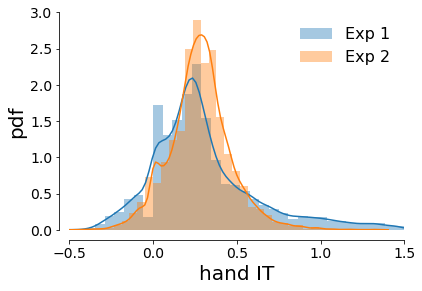

In [51]:
ax = sns.distplot(choices_1['hand IT'], bins=40, label=exp_1)
sns.distplot(choices_2['hand IT'], bins=40, label=exp_2, ax=ax)
ax.set_ylabel('pdf')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0, 3)
sns.despine(ax=ax, trim=True, offset=10)
plt.legend(frameon=False)
plt.savefig('figures/hand_IT', bbox_inches='tight')

In Exp 2, the distibution is narrower, indicating that our manipulation (penalties for premature and late responses) works.

Now, let's look at mouse initation times for each coherence level

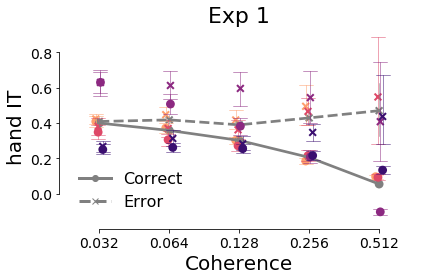

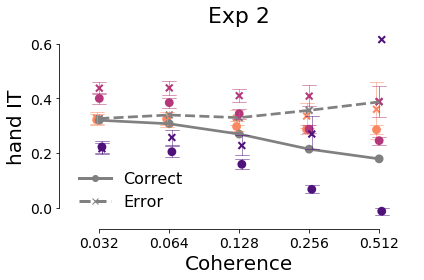

In [19]:
plot_var_vs_coherence(choices_1, exp_1, var='hand IT')
plot_var_vs_coherence(choices_2, exp_2, var='hand IT')

Pretty much what we expect: for all subjects (except for one subject in Exp 1), mouse IT decreases with coherence for correct trials, and remains more-less constant or even increases for error trials __(the 'V-pattern')__. Notably, the V-pattern is way less pronounced in purple participant in Exp 2.

Z-scores highlight the same pattern:

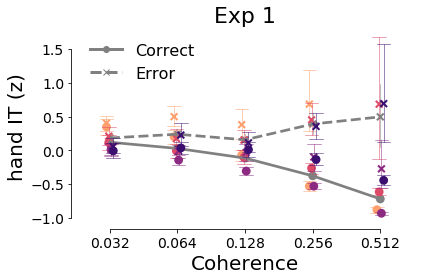

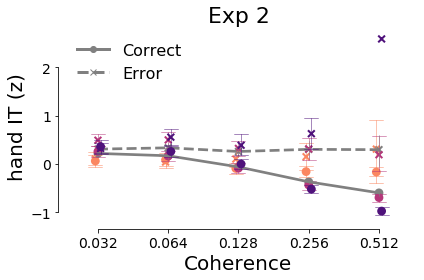

In [20]:
plot_var_vs_coherence(choices_1, exp_1, var='hand IT (z)')
plot_var_vs_coherence(choices_2, exp_2, var='hand IT (z)')

These plotting functions are used for the mouse and eye IT data analyses below

<a name="mouse_IT_correct_error"></a>
## Initiation time in correct vs error trials

Taking into account individual differences in initiation times, it is useful to account for those when looking into initiation times for CoM and non-CoM trials. Here we have to look at z-scored initiation times though, to get general patterns.

After we accounted for magnitude of within-individual initiation times, we can see how relative magnitude of initiation time changes with coherence in non-CoM and CoM trials:

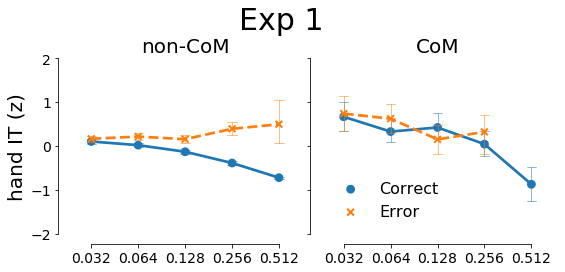

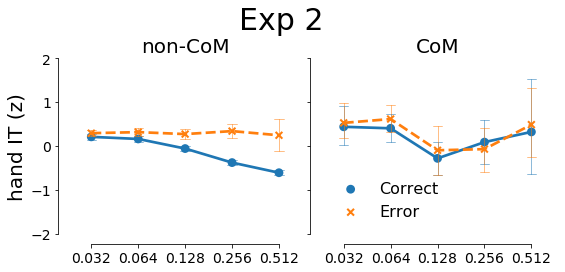

In [135]:
plot_var_grid(choices_1, exp_1, var='hand IT (z)', col='type', hue='choice', 
              hue_order=['Correct', 'Error'],  col_order=['non-CoM', 'CoM'], markers=['o', 'x'], xlabels=False)
plot_var_grid(choices_2, exp_2, var='hand IT (z)', col='type', hue='choice', 
              hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'], xlabels=False)

Surprisingly, in CoM trials participants exhibit identical relative initiation times in correct and error trials! This was observed in both experiments. In individual patterns it's harder to see this though.

In [ ]:
plot_var_grid_individual(choices_1, exp_1, var='hand IT (z)', col='type', hue='choice', 
                        hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'])
plot_var_grid_individual(choices_2, exp_2, var='hand IT (z)', col='type', hue='choice',
                        hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'])

<a name="mouse_IT_CoM"></a>
## Initiation time in CoM vs non-CoM trials

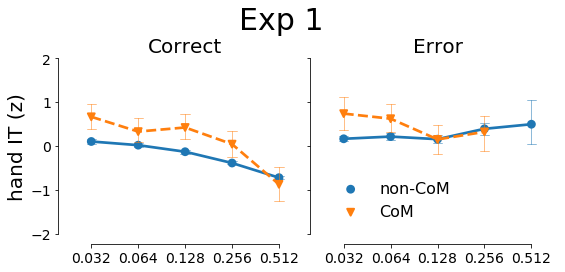

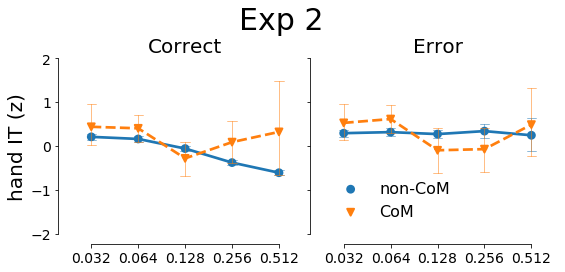

In [136]:
plot_var_grid(choices_1, exp_1, var='hand IT (z)', col='choice', hue='type', 
              hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'], xlabels=False)
plot_var_grid(choices_2, exp_2, var='hand IT (z)', col='choice', hue='type', 
              hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'], xlabels=False)

In Exp 1, correct initation times are reliably longer than those in error trials. This effect diminishes in Exp 2 though.

In [ ]:
plot_var_grid_individual(choices_1, exp_1, var='mouse_IT_z', col='is_correct', hue='is_com')
plot_var_grid_individual(choices_2, exp_2, var='mouse_IT_z', col='is_correct', hue='is_com')

<a name="eye_IT"></a>
# Eye initation time

Next, we look at eye latency (termed eye initiation time for consistency)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


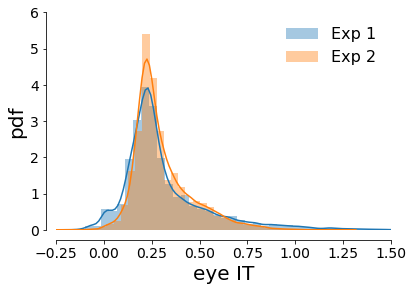

In [59]:
ax = sns.distplot(choices_1['eye IT'], bins=40, label=exp_1)
sns.distplot(choices_2['eye IT'], bins=40, label=exp_2, ax=ax)
ax.set_ylabel('pdf')
ax.set_xlim(-0.25, 1.5)
ax.set_ylim(0, 6)
sns.despine(ax=ax, trim=True, offset=10)
plt.legend(frameon=False)
plt.savefig('figures/eye_IT', bbox_inches='tight')

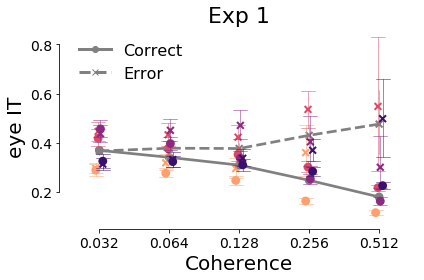

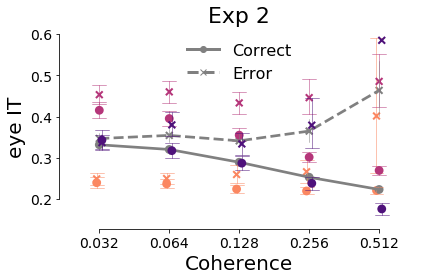

In [60]:
plot_var_vs_coherence(choices_1, exp_1, var='eye IT', estimator=np.nanmean)
plot_var_vs_coherence(choices_2, exp_2, var='eye IT', estimator=np.nanmean)

The overall pattern is very similar to mouse IT. In Exp 1, there are basically no individual differences. In Exp 2, one participant had very low eye IT for all coherence level and correct/error trials, but the < pattern still seems to be there.

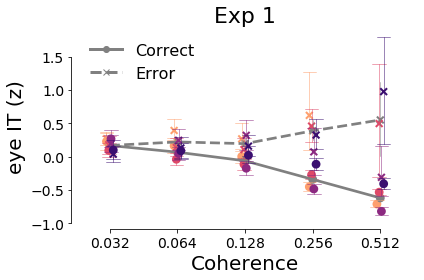

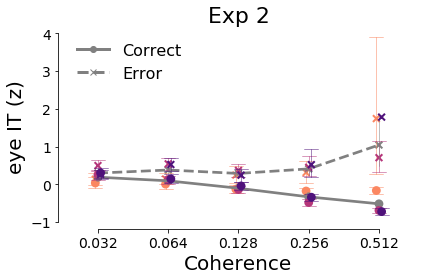

In [62]:
plot_var_vs_coherence(choices_1, exp_1, var='eye IT (z)', estimator=np.nanmean)
plot_var_vs_coherence(choices_2, exp_2, var='eye IT (z)', estimator=np.nanmean)

<a name="eye_IT_correct_error"></a>
## Initiation time in correct vs error trials

Based on differences in correct/error mouse_IT pattern between CoM and non-CoM trials, one would expect similar difference in eye initiation times as well (given that in general, eye IT follows the same '<' pattern). Let's see if this is actually the case:

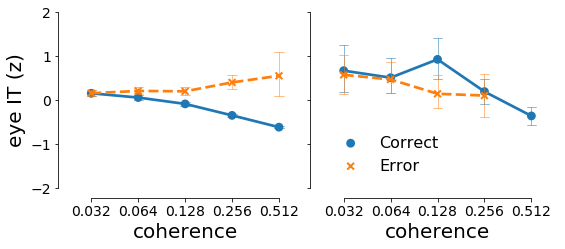

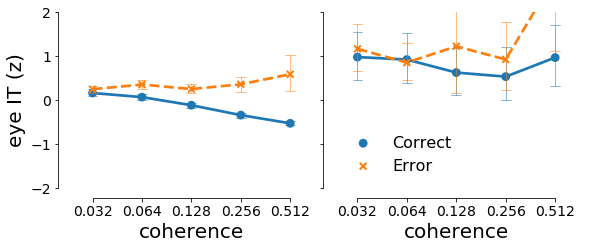

In [137]:
plot_var_grid(choices_1, exp_1, var='eye IT (z)', col='type', hue='choice', 
              hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'], title=False)
plot_var_grid(choices_2, exp_2, var='eye IT (z)', col='type', hue='choice', 
              hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'], title=False)

It turns out that we can actually see the difference between correct and error CoM trials in eye initiation times! But we have just seen that this is not the case in mouse IT... Why is that so?

Strangely, though, in Exp 1 correct CoM's had slower eye initiation than error CoM, but this was reversed in Exp 2. Is it due to experimental manipulation or individual differences? 

In [ ]:
# run this to see same plots for each participant (beware there is little data in each condition then)
plot_var_grid_individual(choices_1[(choices_1.subj_id == 269) | (choices_1.subj_id == 391)], exp_1, 
                         var='eye IT (z)', col='type', hue='choice',
                        hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'])
plot_var_grid_individual(choices_2, exp_2, var='eye IT (z)', col='type', hue='choice',
                        hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'])

<a name="eye_IT_CoM"></a>
## Initiation time in CoM vs non-CoM trials

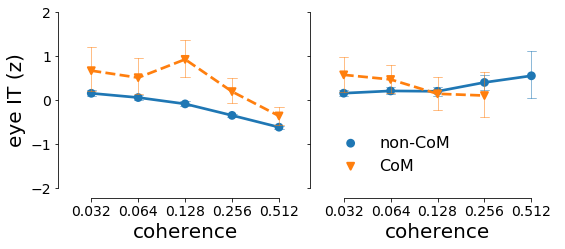

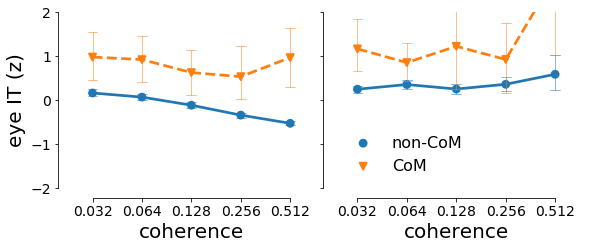

In [138]:
plot_var_grid(choices_1, exp_1, var='eye IT (z)', col='choice', hue='type',
                        hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'], title=False)
plot_var_grid(choices_2, exp_2, var='eye IT (z)', col='choice', hue='type',
                        hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'], title=False)

The effect of longer IT in CoM trials is much more pronounced in eye movements, and shows up in both experiments. In Exp 2, it is kinda there even for error trials.

<a name="negative"></a>
# Negative initiation times

Premature responses were observed in approx. 10% trials in Exp 1, and more than twice less often in Exp 2.

In [102]:
def print_neg_IT_proportion(choices):
    print(len(choices[(choices['hand IT']<0)])/len(choices))

print_neg_IT_proportion(choices_1)
print_neg_IT_proportion(choices_2)

0.09516005681197422
0.04066676246587153


However, the rate of premature responses among CoM trials is much lower

In [103]:
print_neg_IT_proportion(choices_1[choices_1.is_com])
print_neg_IT_proportion(choices_2[choices_2.is_com])

0.013157894736842105
0.018867924528301886


Let's see whether the probability of premature response changes with coherence

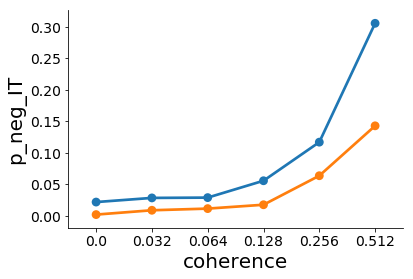

In [107]:
def get_p_neg_IT(choices):
    return (choices.groupby(by=['coherence']).apply(lambda c: len(c[c['hand IT']<0])/len(c)).rename('p_neg_IT').reset_index())
    
fig = plt.figure()
ax = fig.add_subplot(111)
sns.pointplot(data=get_p_neg_IT(choices_1), x='coherence', y='p_neg_IT', ci=None, ax=ax, color='C0')
sns.pointplot(data=get_p_neg_IT(choices_2), x='coherence', y='p_neg_IT', ci=None, ax=ax, color='C1')